# Investigación y Pruebas con JAX

Este cuaderno presenta una investigación sobre **JAX**, la librería desarrollada por Google para computación numérica de alto rendimiento. Se analizan sus diferencias fundamentales con otros frameworks como TensorFlow y PyTorch, se explora su ecosistema y se realizan pruebas prácticas de sus funciones principales.

## 1. ¿Qué es JAX?
JAX es una librería diseñada para la investigación en aprendizaje automático y computación numérica. Se puede definir técnicamente como una combinación de **NumPy acelerado** (para GPU y TPU) y **Autograd** (diferenciación automática).

Su objetivo principal es permitir transformaciones de funciones matemáticas de manera eficiente. Actualmente, es utilizada en proyectos de investigación de gran escala, incluyendo trabajos de DeepMind.

### Características Principales
* **XLA (Accelerated Linear Algebra):** Compila y optimiza el código para ejecutarse rápidamente en aceleradores de hardware.
* **Transformaciones de funciones:** Permite calcular gradientes, compilar código (JIT) y vectorizar operaciones automáticamente.
* **API familiar:** Su sintaxis es casi idéntica a la de NumPy, lo que facilita su adopción.

## 2. Comparación: JAX vs. TensorFlow y PyTorch
A diferencia de TensorFlow y PyTorch, que son frameworks completos de Deep Learning con capas y modelos predefinidos, JAX presenta un enfoque diferente:

1.  **Programación Funcional Pura:** JAX favorece un estilo funcional. Las funciones no mantienen un estado interno (stateless). Para entrenar una red neuronal, los parámetros deben pasarse explícitamente a la función en cada paso, a diferencia de los objetos con estado de PyTorch (`nn.Module`).
2.  **Inmutabilidad:** Las estructuras de datos (arrays) en JAX son inmutables. No es posible modificar un valor de un array existente; se debe crear uno nuevo. Esto contrasta con los tensores mutables de PyTorch o los arrays de NumPy.
3.  **Nivel de Abstracción:** JAX es de más bajo nivel. Proporciona las herramientas matemáticas base, mientras que PyTorch ofrece bloques de construcción listos para usar.

### Ecosistema
Debido a su naturaleza de bajo nivel, existen varias librerías construidas sobre JAX para facilitar el desarrollo de redes neuronales:
* **Flax:** Librería flexible para redes neuronales.
* **Haiku:** Desarrollada por DeepMind, orientada a la investigación.
* **Optax:** Librería para optimizadores de gradiente.

### Nota sobre la Aleatoriedad en JAX
Un aspecto crítico descubierto durante la investigación es el manejo de números aleatorios. A diferencia de NumPy, JAX controla la aleatoriedad de forma explícita mediante claves (`PRNGKey`). Esto garantiza que el código sea reproducible y paralelizable, pero obliga a "dividir" las claves manualmente para generar nuevos números.

In [2]:
# Importación de librerías necesarias
import jax
import jax.numpy as jnp
import numpy as np
import time

# Verificación del dispositivo de ejecución (CPU, GPU o TPU)
print("Dispositivo activo para JAX:", jax.devices())

Dispositivo activo para JAX: [CpuDevice(id=0)]


## 3. Ejemplo Práctico: Diferenciación Automática (`grad`)
La función `jax.grad` permite calcular derivadas de funciones numéricas automáticamente. Esto es fundamental para el algoritmo de retropropagación (backpropagation) en redes neuronales.

A continuación, se define la función $f(x) = x^2 + 3x$ y se calcula su derivada.

In [3]:
def funcion_ejemplo(x):
    return x**2 + 3*x

# Cálculo automático de la derivada: f'(x) = 2x + 3
derivada_fn = jax.grad(funcion_ejemplo)

valor = 4.0
resultado = derivada_fn(valor)

print(f"Evaluación de la función en x={valor}: {funcion_ejemplo(valor)}")
print(f"Evaluación de la derivada en x={valor}: {resultado}")
# Verificación: 2*4 + 3 = 11.0

Evaluación de la función en x=4.0: 28.0
Evaluación de la derivada en x=4.0: 11.0


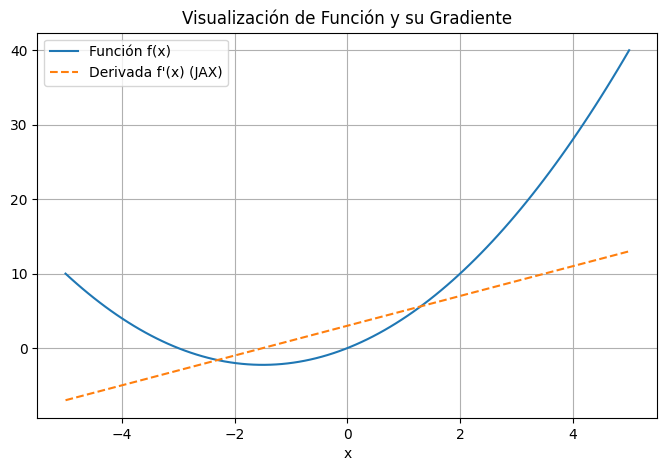

In [7]:
# --- CELDA OPCIONAL: Visualización ---
import matplotlib.pyplot as plt

# Generamos puntos para la gráfica
x_range = jnp.linspace(-5, 5, 100)

# Vectorizamos las funciones para aplicarlas a todo el rango de golpe
f_vect = jax.vmap(funcion_ejemplo)
df_vect = jax.vmap(derivada_fn)

y = f_vect(x_range)
dy = df_vect(x_range)

# Graficamos
plt.figure(figsize=(8, 5))
plt.plot(x_range, y, label='Función f(x)')
plt.plot(x_range, dy, label="Derivada f'(x) (JAX)", linestyle='--')
plt.title("Visualización de Función y su Gradiente")
plt.xlabel("x")
plt.legend()
plt.grid(True)
plt.show()

## 4. Ejemplo Práctico: Compilación JIT (`jit`)
JAX utiliza XLA para compilar y ejecutar código Python de forma optimizada. El decorador `@jax.jit` o la función `jax.jit` permiten compilar una función la primera vez que se llama, acelerando drásticamente las ejecuciones subsiguientes.

Se realiza una comparación de tiempos de ejecución de una operación matricial compleja.

In [4]:
# Definición de una función computacionalmente costosa (ej. activación SELU)
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

# Generación de datos aleatorios (1 millón de elementos)
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, (1000000,))

# 1. Ejecución estándar (sin compilación)
start_time = time.time()
selu(x).block_until_ready()
print(f"Tiempo de ejecución SIN JIT: {time.time() - start_time:.5f} segundos")

# 2. Ejecución con JIT
selu_jit = jax.jit(selu)
# Fase de calentamiento (compilación)
selu_jit(x).block_until_ready()

# Medición del tiempo optimizado
start_time = time.time()
selu_jit(x).block_until_ready()
print(f"Tiempo de ejecución CON JIT: {time.time() - start_time:.5f} segundos")

Tiempo de ejecución SIN JIT: 0.19685 segundos
Tiempo de ejecución CON JIT: 0.00131 segundos


## 5. Ejemplo Práctico: Vectorización Automática (`vmap`)
La función `vmap` permite transformar una función diseñada para operar sobre un solo dato, en una función que opera sobre un lote (batch) completo de datos simultáneamente, eliminando la necesidad de bucles `for` manuales y aprovechando el paralelismo del hardware.

In [5]:
# Función simple: producto punto de dos vectores
def producto_punto(v1, v2):
    return jnp.dot(v1, v2)

# Creación de un lote (batch) de vectores
batch_size = 10
v1_batch = jnp.ones((batch_size, 3))
v2_batch = jnp.ones((batch_size, 3)) * 2  # Vectores de '2'

# Aplicación vectorizada
vectorized_dot = jax.vmap(producto_punto)
resultados = vectorized_dot(v1_batch, v2_batch)

print("Forma del resultado:", resultados.shape)
print("Valores resultantes del lote:", resultados)

Forma del resultado: (10,)
Valores resultantes del lote: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]


## 6. Conclusiones
Tras las pruebas realizadas, se concluye que JAX ofrece una ventaja significativa en rendimiento (gracias a XLA y JIT) y flexibilidad matemática (gracias a `grad` y `vmap`). Sin embargo, su curva de aprendizaje es ligeramente mayor que la de PyTorch debido al paradigma funcional y la gestión explícita del estado y la aleatoriedad.

## Bibliografía
A continuación se listan los recursos y documentación consultados para la realización de esta actividad:

* **Documentación oficial de JAX:** https://jax.readthedocs.io/
* **Repositorio oficial en GitHub:** https://github.com/google/jax
* **JAX 101 Tutorial:** https://jax.readthedocs.io/en/latest/jax-101/index.html
* **DeepMind Blog - JAX Ecosystem:** https://www.deepmind.com/blog